# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [6]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
from collections import deque


import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

## 2. INICIALIZAR MEDIAPIPE

In [7]:
# Configuración inicial global
mp_hands = mp.solutions.hands

# Optimizar MediaPipe
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.4,  # Reducir confianza
    min_tracking_confidence=0.4,
    model_complexity=0  # Menor complejidad
)

mp_draw = mp.solutions.drawing_utils
dataset_dir = "dataset_11"
model_path = "gesture_model_me_10_pruebas.h5"
sequence_length = 30
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

num_camara = 0

## 3. FUNCIONES PRINCIPALES

In [8]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return [d for d in os.listdir(dataset_dir) 
           if os.path.isdir(os.path.join(dataset_dir, d))]

## 4. DETECCION DE MANO

In [9]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## 5. RECOLLECION DE DATOS 

In [10]:
def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)
            
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        cv2.imshow("Recolección de Datos", frame)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## 6. CARGA DE DATOS

In [11]:
def load_data():
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
    
    return np.array(X), np.array(y), gestures


## 7. ENTRENAMIENTO DEL MODELO

In [12]:
def train_model():
    global X_mean, X_std, gestures
    
    # 1. Verificar datos de entrenamiento
    gestures = get_existing_gestures()
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    # 2. Cargar y preparar datos
    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data()
    y = tf.keras.utils.to_categorical(y)

    # 3. Calcular parámetros de normalización
    X_mean = np.mean(X, axis=(0, 1))
    X_std = np.std(X, axis=(0, 1))
    X = (X - X_mean) / X_std  # Normalización

    # 4. Guardar parámetros de normalización
    np.savez('normalization_params_pruebas.npz', mean=X_mean, std=X_std)
    
    # 5. Arquitectura optimizada del modelo
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, 4, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # 6. Compilación y entrenamiento
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=1
    )
    #Graficos
    def generate_training_plots(history):
            plt.figure(figsize=(12, 5))
            
            # Gráfico de precisión
            plt.subplot(1, 2, 1)
            plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
            plt.plot(history.history['val_accuracy'], label='Precisión Validación')
            plt.title('Precisión durante Entrenamiento')
            plt.ylabel('Precisión')
            plt.xlabel('Época')
            plt.legend()
            
            # Gráfico de pérdida
            plt.subplot(1, 2, 2)
            plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
            plt.plot(history.history['val_loss'], label='Pérdida Validación')
            plt.title('Pérdida durante Entrenamiento')
            plt.ylabel('Pérdida')
            plt.xlabel('Época')
            plt.legend()
            
            plt.tight_layout()
            plt.savefig('training_metrics.png')
            plt.show()

    def generate_confusion_matrix(model, X, y):
        y_true = np.argmax(y, axis=1)
        y_pred = np.argmax(model.predict(X), axis=1)
            
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=gestures, 
                        yticklabels=gestures)
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicciones')
        plt.ylabel('Verdaderos')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
            
        # Imprimir reporte de clasificación
        print("\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred, target_names=gestures))

    # 7. Guardar modelo y resultados
    model.save(model_path)
    generate_training_plots(history)
    generate_confusion_matrix(model, X, y)
    print(f"\nModelo guardado en {model_path}")
    
    # 8. Conversión a TFLite con configuraciones especiales
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    try:
        tflite_model = converter.convert()
        with open('model_quantized_pruebas.tflite', 'wb') as f:
            f.write(tflite_model)
        print("\nModelo TFLite exportado exitosamente")
    except Exception as e:
        print(f"\nError en conversión TFLite: {str(e)}")
    
    # Mostrar métricas finales
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

## TF LITE

In [13]:
def convert_to_tflite():
    try:
        # Cargar el modelo entrenado
        model = tf.keras.models.load_model(model_path)
        
        # Configurar el conversor con parámetros especiales
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        
        # Añadir estas 3 líneas clave para compatibilidad con LSTM
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False
        converter.allow_custom_ops = True  # Permitir operaciones personalizadas
        
        # Realizar la conversión
        tflite_model = converter.convert()
        
        # Guardar el modelo cuantizado
        with open('model_quantized_pruebas.tflite', 'wb') as f:
            f.write(tflite_model)
            
        print("\n✅ Conversión a TFLite exitosa!")
        
    except Exception as e:
        print(f"\n❌ Error en conversión: {str(e)}")
        print("Posibles soluciones:")
        print("1. Verifique que el modelo .h5 existe")
        print("2. Actualice TensorFlow: pip install --upgrade tensorflow")
        print("3. Reinicie el runtime/kernel")

def representative_dataset_gen():
    # Generador de datos de ejemplo para calibración
    for _ in range(100):
        yield [np.random.randn(1, sequence_length, total_landmarks).astype(np.float32)]

## 8. EVALUACION DEL MODELO

In [14]:
# ------------------ IMPORTS ADICIONALES NECESARIOS ------------------
from collections import deque
from threading import Thread
from queue import Queue


# ------------------ SECCIÓN DE CONFIGURACIÓN ------------------
# Añadir al inicio con las demás configuraciones
frame_queue = Queue(maxsize=30)
landmark_queue = Queue(maxsize=20)
prediction_queue = Queue(maxsize=10)

# ------------------ FUNCIÓN CAMERA_CAPTURE ------------------
def camera_capture(cap):
    while True:
        ret, frame = cap.read()
        if ret:
            resized_frame = cv2.resize(frame, (320, 240))
            frame_queue.put(resized_frame)

# ------------------ FUNCIÓN LANDMARK_PROCESSING ------------------
def landmark_processing():
    while True:
        frame = frame_queue.get()
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        all_landmarks = np.zeros(total_landmarks, dtype=np.float32)
        if results.multi_hand_landmarks:
            idx = 0
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks[idx:idx+3] = [lm.x, lm.y, lm.z]
                    idx += 3
        landmark_queue.put(all_landmarks)

# ------------------ FUNCIÓN MODEL_INFERENCE ------------------
def model_inference(interpreter, input_details, output_details):
    while True:
        data = landmark_queue.get()
        if data is not None:
            sequence.append(data)
            sequence = sequence[-sequence_length:]
            
            if len(sequence) == sequence_length:
                seq_array = (np.array(sequence) - X_mean) / X_std
                input_data = seq_array.reshape(1, sequence_length, total_landmarks).astype(np.float32)
                
                interpreter.set_tensor(input_details[0]['index'], input_data)
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details[0]['index'])[0]
                
                predicted_class = np.argmax(prediction)
                confidence = np.max(prediction)
                prediction_queue.put((gestures[predicted_class], confidence))



In [15]:
from threading import Thread
def evaluate():
    if not os.path.exists("model_quantized_pruebas.tflite"):
        print("\n¡Primero debe entrenar y convertir el modelo!")
        return
    
    # 1. Cargar parámetros y modelo
    try:
        with np.load('normalization_params_pruebas.npz') as data:
            X_mean = data['mean']
            X_std = data['std']
            
        interpreter = tf.lite.Interpreter(model_path="model_quantized_pruebas.tflite")
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]  # Mantener [0]
        output_details = interpreter.get_output_details()[0]
    except Exception as e:
        print(f"\nError crítico: {str(e)}")
        return

    # 2. Configuración de cámara
    cap = cv2.VideoCapture(0)  # Forzar backend DirectShow
    #import time
    #time.sleep(2)  # Permitir inicialización de cámara
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    #cap.set(cv2.CAP_PROP_FPS, 30)
    
    if not cap.isOpened():
        print("\n¡No se puede acceder a la cámara!")
        return

    # 3. Variables de estado
    current_gesture = None  # Variable para almacenar la última seña detectada
    current_confidence = 0.0
    sequence = deque(maxlen=sequence_length)  # Usar deque
    #last_gesture = None
    frame_counter = 0
    #prediction_active = False

    # 4. Bucle principal
    while True:
        # 4.1 Capturar frame
        ret, frame = cap.read()
        if not ret:
            print("\nError en captura de frame")
            break
            
        frame_counter += 1
        
        # 4.2 Procesamiento cada 2 frames
        if frame_counter % 2 != 0:
            continue
            
        # 4.3 Detección de landmarks
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        
        if results.multi_hand_landmarks:
            # 4.4 Extraer landmarks
            landmarks = []
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar si solo hay una mano
            if len(results.multi_hand_landmarks) < 2:
                landmarks += [0.0] * (total_landmarks - len(landmarks))
                
            # El deque ya maneja automáticamente el tamaño máximo gracias a maxlen
            sequence.append(landmarks)  # Esto mantendrá solo los últimos 'sequence_length' elementos
            
            
            # 4.5 Dibujar landmarks
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                

                # Añadir verificación de dimensión de entrada
            if input_details['shape'][1] != sequence_length:
                print("\nError: Dimensiones del modelo no coinciden con la configuración")
                return
            
            # 4.6 Realizar predicción cada 1 segundo (30 frames)
            if len(sequence) == sequence_length and frame_counter % 30 == 0:
                try:
                    # Preprocesamiento CORREGIDO
                    seq_array = np.array(sequence)
                    seq_array = (seq_array - X_mean) / (X_std + 1e-7)  # +epsilon para seguridad
                    
                    # Asegurar 3 dimensiones: [batch_size=1, sequence_length, features]
                    input_data = seq_array.reshape(1, sequence_length, total_landmarks).astype(np.float32)
                    
                    # Debug: Verificar forma
                    
                    print("Forma de entrada:", input_data.shape)  # Debe mostrar (1, 30, 126)

                    # Inferencia
                    interpreter.set_tensor(input_details['index'], input_data)
                    interpreter.invoke()
                    prediction = interpreter.get_tensor(output_details['index'])[0]
                    
                    # Procesar resultados
                    predicted_idx = np.argmax(prediction)
                    confidence = prediction[predicted_idx]
                    
                    if confidence > 0.6:
                        current_gesture = gestures[predicted_idx]  # Actualizar solo si hay alta confianza
                        current_confidence = confidence
                        print("Nueva seña detectada:", current_gesture)
                        
                        # Actualizar UI
                        #cv2.putText(frame, f"{current_gesture} ({confidence:.2%})", 
                        #          (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                        
                        cv2.putText(frame, f"{current_gesture} ({confidence:.2%})", 
                            (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)
                        
                        print("La seña es: ", current_gesture)

                        """# Reproducir voz
                        if current_gesture != last_gesture:
                            threading.Thread(target=voice_system.speak, 
                                           args=(current_gesture,)).start()
                            last_gesture = current_gesture"""
                            
                except Exception as e:
                    print(f"Error en predicción: {str(e)}")
                    current_gesture = None  # Resetear si hay error
                    
        if current_gesture:
            cv2.putText(frame, 
              f"{current_gesture} ({current_confidence:.2%})", 
              (10, 50), 
              cv2.FONT_HERSHEY_SIMPLEX, 
              1, 
              (0, 255, 0), 
              2)



        # Mostrar frame reducido
        cv2.imshow("Predicciones", cv2.resize(frame, (640, 480)))
        
        if cv2.waitKey(1) & 0xFF == 27: break
        
        # 4.8 Salir con ESC
        if cv2.waitKey(1) & 0xFF == 27:
            break

    # 5. Limpieza
    cap.release()
    cv2.destroyAllWindows()
    print("\nSistema de evaluación detenido")

In [16]:
def evaluate_with_plots():
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    # Cargar modelo y datos
    model = load_model(model_path)
    X, y, _ = load_data()
    y = tf.keras.utils.to_categorical(y)
    
    # Preprocesamiento
    X = (X - X_mean) / X_std
    
    # Predicciones
    y_pred = model.predict(X)
    y_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)
    
    # 1. Matriz de Confusión
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=gestures, yticklabels=gestures)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 2. Reporte de Clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_true, y_classes, target_names=gestures))

    # 3. Curvas ROC por Clase
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        fpr, tpr, _ = roc_curve(y_true, y_pred[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{gestures[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC por Clase')
    plt.legend(loc="lower right")
    plt.show()

    # 4. Precisión vs Recall
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:,i], pos_label=i)
        plt.plot(recall, precision, label=gestures[i])
    
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curvas Precisión-Recall')
    plt.legend(loc="best")
    plt.show()

    # 5. Distribución de Probabilidades
    plt.figure(figsize=(10, 6))
    for i in range(len(gestures)):
        sns.kdeplot(y_pred[y_true == i][:,i], label=gestures[i])
    
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.title('Distribución de Probabilidades por Clase')
    plt.legend()
    plt.show()


## 9. REENTRENAR GESTO

In [17]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(dataset_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## 10. MENU

In [18]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo, y despues ir a convertir a TFlite")
        print("4. Evaluar")
        print("5. Evaluar con Graficos")
        print("6. Reentrenar Gesto")
        print("7. Convertir a TFLite")  # Nueva opción
        print("8. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            evaluate_with_plots()
        elif choice == '6':
            retrain_gesture()
        elif choice == '7':  # Nueva opción de conversión
            convert_to_tflite()
        elif choice == '8':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Evaluar con Graficos
6. Reentrenar Gesto
7. Convertir a TFLite
8. Salir

Cargando datos y preparando el entrenamiento...

Iniciando entrenamiento...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1276 - loss: 1.7684 - val_accuracy: 0.0000e+00 - val_loss: 2.0475
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3385 - loss: 1.6701 - val_accuracy: 0.0000e+00 - val_loss: 2.0377
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5117 - loss: 1.5394 - val_accuracy: 0.0000e+00 - val_loss: 2.0369
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5599 - loss: 1.4555 - val_accuracy: 0.0000e+00 - val_loss: 2.0307
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7057 - loss: 1.3583 - val_accuracy: 0.0000e+00 - val_loss: 2.0262
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/s

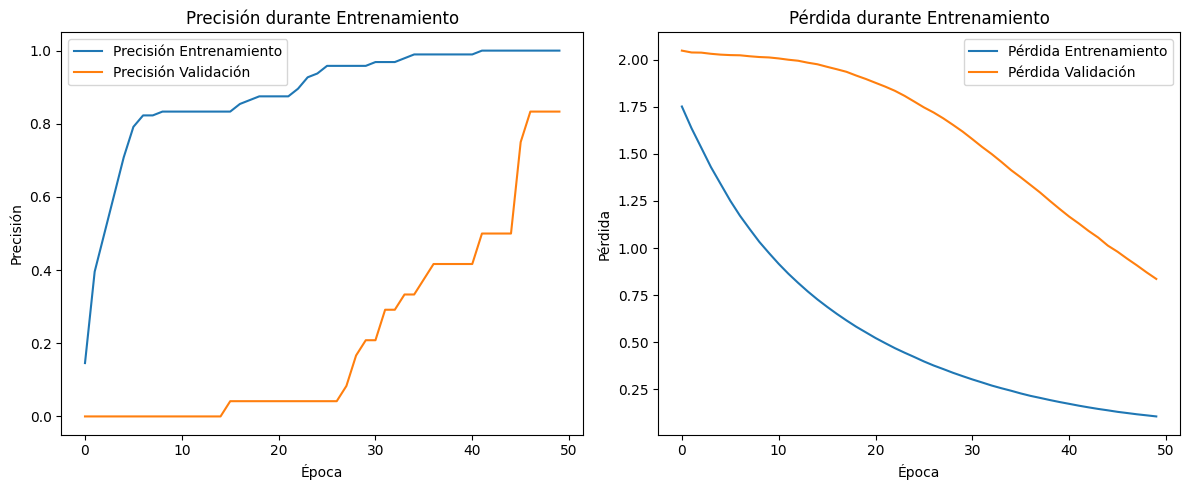

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


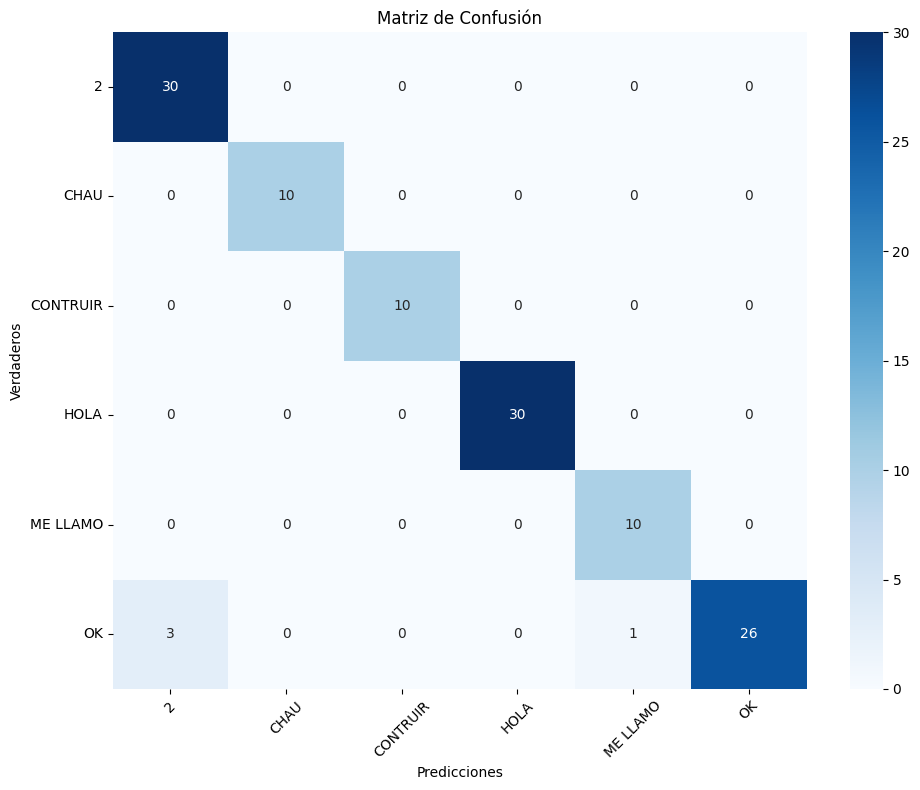


Reporte de Clasificación:
              precision    recall  f1-score   support

           2       0.91      1.00      0.95        30
        CHAU       1.00      1.00      1.00        10
    CONTRUIR       1.00      1.00      1.00        10
        HOLA       1.00      1.00      1.00        30
    ME LLAMO       0.91      1.00      0.95        10
          OK       1.00      0.87      0.93        30

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.97      0.97      0.97       120


Modelo guardado en gesture_model_me_10_pruebas.h5
INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpc4jvuu0k\assets


INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpc4jvuu0k\assets


Saved artifact at 'C:\Users\juanp\AppData\Local\Temp\tmpc4jvuu0k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 126), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2380990405920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990410848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990698720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990702064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990704704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990704000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2380990701008: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo TFLite exportado exitosamente
Precisión de validación final: 83.33%

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir 

INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpyqaaio50\assets


INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpyqaaio50\assets


Saved artifact at 'C:\Users\juanp\AppData\Local\Temp\tmpyqaaio50'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 126), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2381145637280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145642208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145651712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145649952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145645728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145650480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2381145652240: TensorSpec(shape=(), dtype=tf.resource, name=None)

✅ Conversión a TFLite exitosa!

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Evaluar con Graficos
6

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


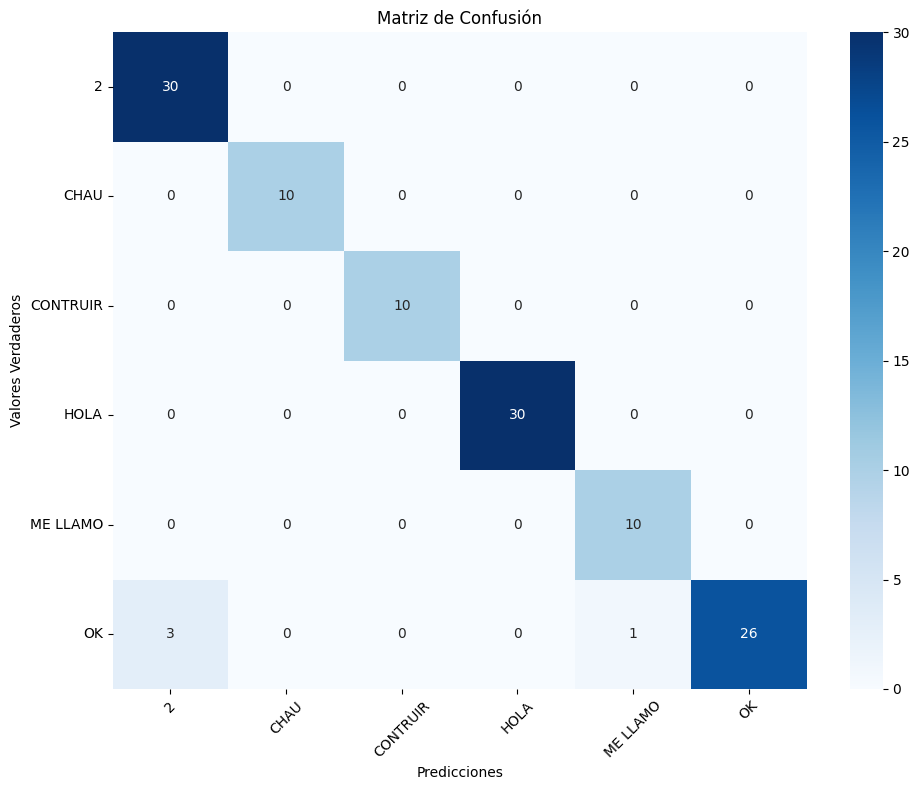


Reporte de Clasificación:
              precision    recall  f1-score   support

           2       0.91      1.00      0.95        30
        CHAU       1.00      1.00      1.00        10
    CONTRUIR       1.00      1.00      1.00        10
        HOLA       1.00      1.00      1.00        30
    ME LLAMO       0.91      1.00      0.95        10
          OK       1.00      0.87      0.93        30

    accuracy                           0.97       120
   macro avg       0.97      0.98      0.97       120
weighted avg       0.97      0.97      0.97       120



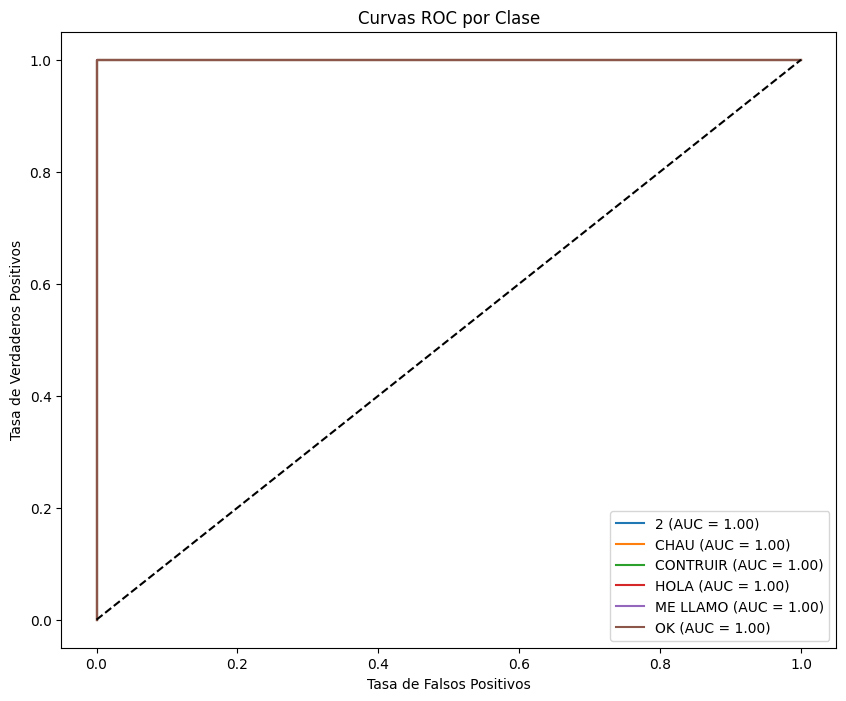

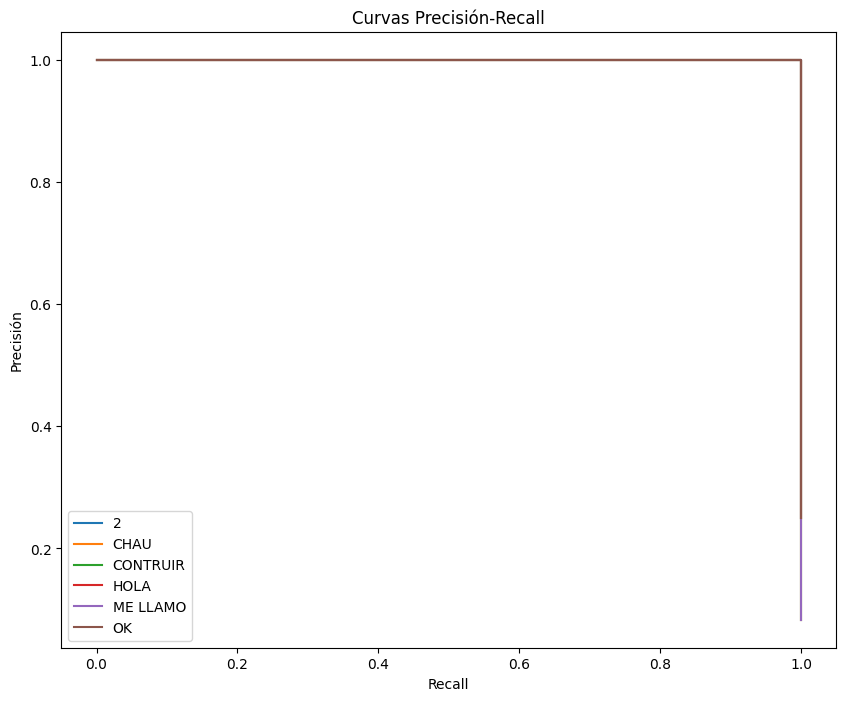

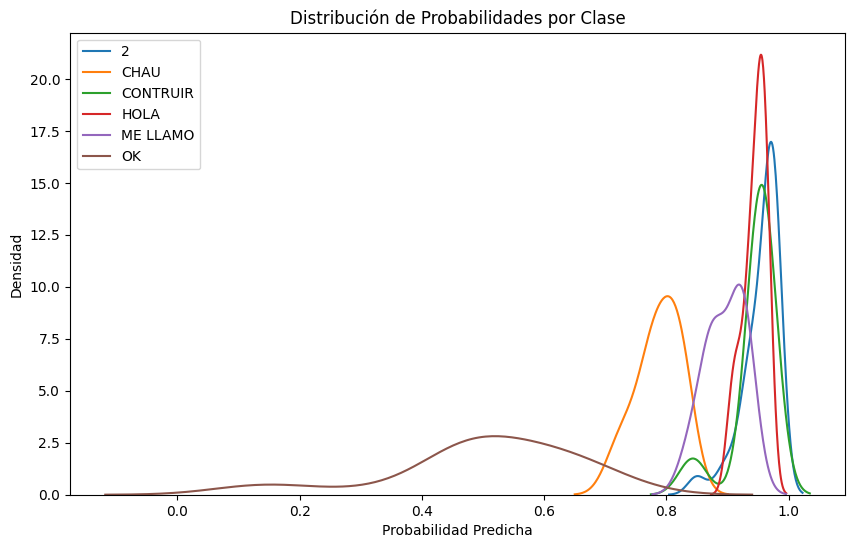


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Evaluar con Graficos
6. Reentrenar Gesto
7. Convertir a TFLite
8. Salir

¡Hasta luego!


In [19]:
if __name__ == "__main__":
    main()